## Proyecto Security Data Science

### Fase 2: Modelo base, Métricas personalizadas y Función optimización.

### Miembros
* Fernanda Esquivel - 21542

### Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FerEsq/SDS-Project)

## Implementación del modelo base

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
#Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

In [6]:
#Cargar los datasets
train_data = pd.read_csv('dataset/credit_card_fraud_features_train_madrugada.csv')
test_data = pd.read_csv('dataset/credit_card_fraud_features_test_madrugada.csv')
is_night_data = True

In [7]:
print(f"Dimensiones del conjunto de entrenamiento: {train_data.shape}")
print(f"Dimensiones del conjunto de prueba: {test_data.shape}")

Dimensiones del conjunto de entrenamiento: (629424, 75)
Dimensiones del conjunto de prueba: (112442, 75)


In [8]:
#Comprobar balance de clases
print("\nBalance de clases en el conjunto de entrenamiento:")
train_fraud_count = train_data['is_fraud'].value_counts()
train_fraud_pct = train_data['is_fraud'].value_counts(normalize=True) * 100
for i, (count, pct) in enumerate(zip(train_fraud_count, train_fraud_pct)):
    print(f"{'Fraude' if i == 1 else 'No fraude'}: {count} ({pct:.4f}%)")


Balance de clases en el conjunto de entrenamiento:
No fraude: 621687 (98.7708%)
Fraude: 7737 (1.2292%)


In [9]:
print("\nBalance de clases en el conjunto de prueba:")
test_fraud_count = test_data['is_fraud'].value_counts()
test_fraud_pct = test_data['is_fraud'].value_counts(normalize=True) * 100
for i, (count, pct) in enumerate(zip(test_fraud_count, test_fraud_pct)):
    print(f"{'Fraude' if i == 1 else 'No fraude'}: {count} ({pct:.4f}%)")


Balance de clases en el conjunto de prueba:
No fraude: 111670 (99.3134%)
Fraude: 772 (0.6866%)


### Preparación del dataset para el entrenamiento

In [10]:
#Columnas que definitivamente no sirven como features
exclude_cols = [
    'cc_num', 'first', 'last', 'trans_num', 'street', 'city', 'state', 'job', 
    'dob', 'merchant', 'date', 'month_year', 'datetime', 'first_tx_date', 'birth_date'
]

In [11]:
#Quitar columnas que no sirven como features
train_features = train_data.drop(columns=[col for col in exclude_cols if col in train_data.columns])
test_features = test_data.drop(columns=[col for col in exclude_cols if col in test_data.columns])

In [12]:
#Identificar columnas categóricas (object o category) y columns que son tipo bool
cat_cols = [col for col in train_features.columns if 
            train_features[col].dtype == 'object' or 
            train_features[col].dtype == 'category' or
            train_features[col].dtype == 'bool']

In [13]:
#Convertir columnas booleanas a enteros (0/1)
for col in train_features.columns:
    if train_features[col].dtype == 'bool':
        train_features[col] = train_features[col].astype(int)
        test_features[col] = test_features[col].astype(int)

In [14]:
#Verificar la lista de columnas categóricas
print(f"Columnas categóricas identificadas: {cat_cols}")

Columnas categóricas identificadas: ['category', 'gender', 'first_time_at_merchant', 'day_part', 'age_segment', 'category_simplified']


In [15]:
#Preparar las variables predictoras (X) y la variable objetivo (y)
y_train = train_features['is_fraud']
X_train = train_features.drop('is_fraud', axis=1)

y_test = test_features['is_fraud']
X_test = test_features.drop('is_fraud', axis=1)

In [16]:
#One-hot encoding para las variables categóricas
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

In [17]:
#Asegurarse de que train y test tienen las mismas columnas
train_cols = X_train.columns
test_cols = X_test.columns

In [18]:
#Añadir columnas faltantes en test
missing_cols = set(train_cols) - set(test_cols)
for col in missing_cols:
    X_test[col] = 0

In [19]:
#Usar solo columnas de entrenamiento y en el mismo orden
X_test = X_test[train_cols]

In [20]:
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")

Dimensiones de X_train: (629424, 77)
Dimensiones de X_test: (112442, 77)


In [21]:
#Separar una porción del conjunto de entrenamiento para validación
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [22]:
#Crear el conjunto de datos para LightGBM
train_data_lgb = lgb.Dataset(X_train_split, label=y_train_split, categorical_feature='auto')
val_data_lgb = lgb.Dataset(X_val, label=y_val, reference=train_data_lgb, categorical_feature='auto')

In [30]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),  # Para manejar el desbalance
    # 'is_unbalance': True,  # Eliminado este parámetro para evitar el conflicto
    'max_depth': -1,  # No limitar la profundidad
}

### Entrenamiento del modelo

In [24]:
print(f"Ratio de clases (no fraude/fraude): {params['scale_pos_weight']:.2f}")
print(f"Parámetros del modelo:\n{params}")

Ratio de clases (no fraude/fraude): 80.35
Parámetros del modelo:
{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': -1, 'scale_pos_weight': 80.35246219464909, 'is_unbalance': True, 'max_depth': -1}


In [31]:
model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=1000,
    valid_sets=[train_data_lgb, val_data_lgb],
    callbacks=[
        lgb.callback.early_stopping(stopping_rounds=50, verbose=True),
        lgb.callback.log_evaluation(period=50)
    ]
)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.998585	valid_1's auc: 0.996757
[100]	training's auc: 0.999593	valid_1's auc: 0.998131
[150]	training's auc: 0.999812	valid_1's auc: 0.99871
[200]	training's auc: 0.9999	valid_1's auc: 0.998942
[250]	training's auc: 0.999941	valid_1's auc: 0.999054
[300]	training's auc: 0.999967	valid_1's auc: 0.999163
[350]	training's auc: 0.999983	valid_1's auc: 0.999167
Early stopping, best iteration is:
[308]	training's auc: 0.999971	valid_1's auc: 0.999198


In [32]:
#Guardar el modelo
model.save_model('models/fraud_detection_lgb_model.txt')
print("Modelo guardado como 'models/fraud_detection_lgb_model.txt'")

Modelo guardado como 'models/fraud_detection_lgb_model.txt'


In [34]:
#Predicciones
y_pred_val_proba = model.predict(X_val, num_iteration=model.best_iteration)
y_pred_test_proba = model.predict(X_test, num_iteration=model.best_iteration)

### Métricas

In [35]:
print("\nMétricas de evaluación en el conjunto de validación:")
val_auc = roc_auc_score(y_val, y_pred_val_proba)
print(f"AUC-ROC: {val_auc:.4f}")


Métricas de evaluación en el conjunto de validación:
AUC-ROC: 0.9992


In [36]:
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []

In [37]:
for threshold in thresholds:
    y_pred_val = (y_pred_val_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_val)
    f1_scores.append(f1)

In [38]:
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

In [39]:
print(f"Mejor threshold basado en F1-score: {best_threshold:.4f}")
print(f"Mejor F1-score en validación: {best_f1:.4f}")

Mejor threshold basado en F1-score: 0.9300
Mejor F1-score en validación: 0.9384


In [40]:
#Aplicar el mejor threshold a las predicciones
y_pred_val = (y_pred_val_proba >= best_threshold).astype(int)
y_pred_test = (y_pred_test_proba >= best_threshold).astype(int)

In [48]:
#Métricas adicionales en validación
val_confusion = confusion_matrix(y_val, y_pred_val)
val_tn, val_fp, val_fn, val_tp = val_confusion.ravel()
val_precision = val_tp / (val_tp + val_fp) if (val_tp + val_fp) > 0 else 0
val_recall = val_tp / (val_tp + val_fn) if (val_tp + val_fn) > 0 else 0
val_specificity = val_tn / (val_tn + val_fp) if (val_tn + val_fp) > 0 else 0
val_f1 = f1_score(y_val, y_pred_val)

print("\nMétricas detalladas en validación:")
print(f"Precisión: {val_precision:.4f}")
print(f"Recall (Sensibilidad): {val_recall:.4f}")
print(f"Especificidad: {val_specificity:.4f}")
print(f"F1-Score: {val_f1:.4f}")


Métricas detalladas en validación:
Precisión: 0.9515
Recall (Sensibilidad): 0.9257
Especificidad: 0.9994
F1-Score: 0.9384


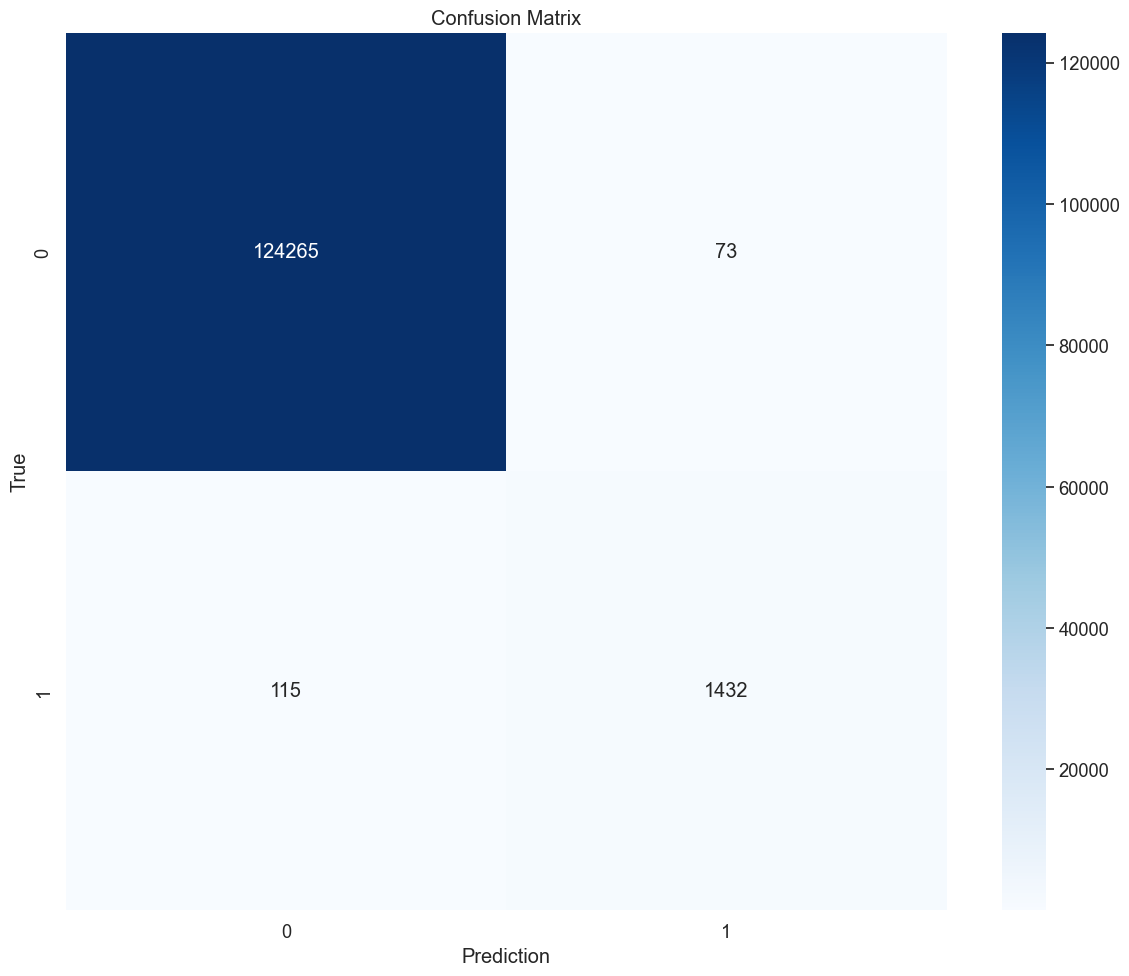

In [49]:
plt.figure(figsize=(12, 10))
sns.heatmap(val_confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [46]:
#Métricas en el conjunto de prueba
test_auc = roc_auc_score(y_test, y_pred_test_proba)
test_confusion = confusion_matrix(y_test, y_pred_test)
test_tn, test_fp, test_fn, test_tp = test_confusion.ravel()
test_precision = test_tp / (test_tp + test_fp) if (test_tp + test_fp) > 0 else 0
test_recall = test_tp / (test_tp + test_fn) if (test_tp + test_fn) > 0 else 0
test_specificity = test_tn / (test_tn + test_fp) if (test_tn + test_fp) > 0 else 0
test_f1 = f1_score(y_test, y_pred_test)

print("\nMétricas en el conjunto de prueba (diciembre):")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precisión: {test_precision:.4f}")
print(f"Recall (Sensibilidad): {test_recall:.4f}")
print(f"Especificidad: {test_specificity:.4f}")
print(f"F1-Score: {test_f1:.4f}")


Métricas en el conjunto de prueba (diciembre):
AUC-ROC: 0.9984
Precisión: 0.9179
Recall (Sensibilidad): 0.8251
Especificidad: 0.9995
F1-Score: 0.8690


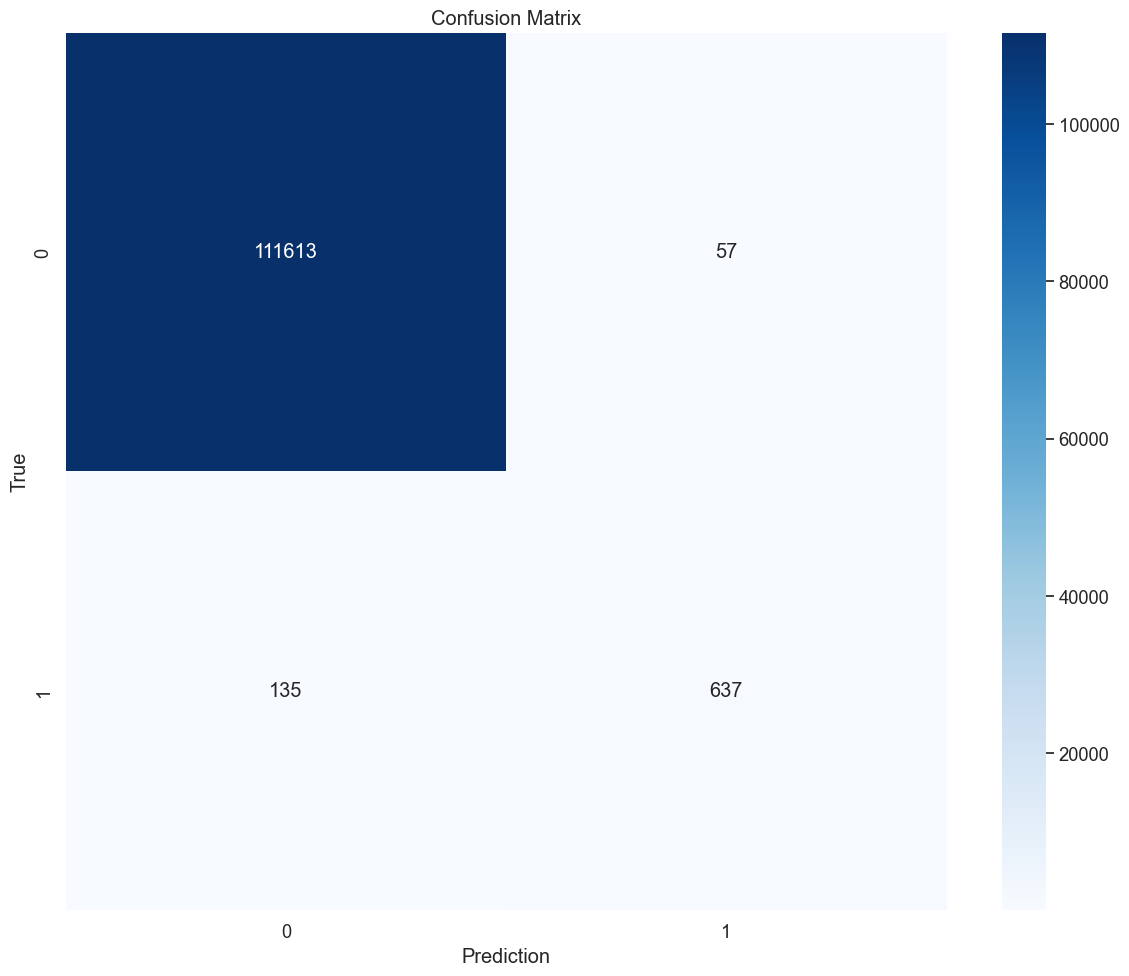

In [47]:
plt.figure(figsize=(12, 10))
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Definición de métricas personalizadas

In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix

### Funciones de Evaluación Personalizadas (feval)

In [ ]:
#Función 1: Penalización directa de falsos positivos
'''
Métrica personalizada para minimizar la relación de falsos positivos por cada verdadero positivo:
ratio_fp = (TP + FP) / TP
'''
def false_positive_ratio_feval(y_pred, dtrain):
    
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred >= 0.5).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    # Evitar división por cero
    if tp == 0:
        return 'fp_ratio', float('inf'), False
    
    fp_ratio = (tp + fp) / tp
    
    # LightGBM minimiza la métrica
    return 'fp_ratio', fp_ratio, False

In [52]:
#Función 2: Optimización de precisión con umbral dinámico
'''
Función que favorece la precisión (reduce falsos positivos) mientras mantiene una tasa de detección razonable.
'''
def precision_oriented_feval(y_pred, dtrain):
    y_true = dtrain.get_label()
    
    # Probamos múltiples umbrales para encontrar el mejor equilibrio
    best_score = float('inf')
    for threshold in np.arange(0.3, 0.95, 0.05):
        y_pred_binary = (y_pred >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
        
        # Calculamos el ratio de falsos positivos
        if tp == 0:
            continue  # Evitar división por cero
        
        fp_ratio = (tp + fp) / tp
        
        # Penalizamos si recall cae por debajo del 90%
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        if recall < 0.9:
            fp_ratio *= (1 + (0.9 - recall) * 5)  # Penalización si recall < 90%
        
        best_score = min(best_score, fp_ratio)
    
    return 'precision_score', best_score, False

In [53]:
#Función 3: Ratio ponderado con énfasis en falsos positivos
'''
Ratio de falsos positivos ponderado que da más peso a los falsos positivos en relación con el objetivo de mantener al menos un 90% de detección.
'''
def weighted_fp_ratio_feval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred >= 0.5).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    # Evitar división por cero
    if tp == 0:
        return 'weighted_fp_ratio', float('inf'), False
    
    # Calculamos las métricas base
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    fp_ratio = (tp + fp) / tp
    
    # Penalización exponencial por falsos positivos, más suave en recall
    weighted_ratio = fp_ratio * (1 + max(0, (0.9 - recall) * 2))
    
    return 'weighted_fp_ratio', weighted_ratio, False

In [54]:
#Función 4: Optimización por costos asimétricos
'''
Evalúa el modelo asignando diferentes costos a distintos tipos de errores.
- Costo de falso positivo: más alto (5)
- Costo de falso negativo: moderado (1)
'''
def cost_sensitive_feval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred >= 0.5).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    # Asignamos costos
    FP_COST = 5.0  # Alto costo para falsos positivos
    FN_COST = 1.0  # Costo moderado para falsos negativos
    
    # Costo total
    total_cost = (fp * FP_COST + fn * FN_COST) / (tp + fn)  # Normalizado por el total de positivos reales
    
    return 'cost_sensitive', total_cost, False

### Implementación y Entrenamiento con Métricas Personalizadas

In [ ]:
#Configuración para entrenamiento con cada función de evaluación personalizada
params_base = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
    'max_depth': -1,
}

In [56]:
#Lista para almacenar modelos y resultados
models = []
results = []

In [57]:
#Entrenamiento con cada feval
feval_functions = [
    ('False Positive Ratio', false_positive_ratio_feval),
    ('Precision Oriented', precision_oriented_feval),
    ('Weighted FP Ratio', weighted_fp_ratio_feval),
    ('Cost Sensitive', cost_sensitive_feval)
]

In [59]:
for name, feval_func in feval_functions:
    print(f"\nEntrenamiento del modelo con {name}:")
    
    #Entrenamiento del modelo
    model = lgb.train(
        params_base,
        train_data_lgb,
        num_boost_round=1000,
        valid_sets=[train_data_lgb, val_data_lgb],
        feval=feval_func,  # Aquí es donde usamos nuestra función personalizada
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=50, verbose=True),
            lgb.callback.log_evaluation(period=50)
        ]
    )
    
    #Guardamos el modelo
    model_path = f'models/fraud_detection_lgb_model_{name.lower().replace(" ", "_")}.txt'
    model.save_model(model_path)
    print(f"Modelo guardado como '{model_path}'")
    
    #Predicciones
    y_pred_val_proba = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_test_proba = model.predict(X_test, num_iteration=model.best_iteration)
    
    #Buscar el mejor umbral para optimizar la detección con minimos falsos positivos
    best_threshold = 0.5
    best_fp_ratio = float('inf')
    
    for threshold in np.arange(0.1, 0.99, 0.01):
        y_pred_val = (y_pred_val_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
        
        #Calculo de recall (queremos mantenerlo alto)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        #Solo consideramos umbrales que mantienen un recall del 90% o mas
        if recall >= 0.9:
            fp_ratio = (tp + fp) / tp if tp > 0 else float('inf')
            if fp_ratio < best_fp_ratio:
                best_fp_ratio = fp_ratio
                best_threshold = threshold
    
    print(f"Mejor umbral encontrado: {best_threshold:.4f}")
    
    #Aplicar el mejor umbral
    y_pred_val = (y_pred_val_proba >= best_threshold).astype(int)
    y_pred_test = (y_pred_test_proba >= best_threshold).astype(int)
    
    #Evaluación en validación
    val_tn, val_fp, val_fn, val_tp = confusion_matrix(y_val, y_pred_val).ravel()
    val_precision = val_tp / (val_tp + val_fp) if (val_tp + val_fp) > 0 else 0
    val_recall = val_tp / (val_tp + val_fn) if (val_tp + val_fn) > 0 else 0
    val_fp_ratio = (val_tp + val_fp) / val_tp if val_tp > 0 else float('inf')
    
    #Evaluación en el conjunto de prueba
    test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test, y_pred_test).ravel()
    test_precision = test_tp / (test_tp + test_fp) if (test_tp + test_fp) > 0 else 0
    test_recall = test_tp / (test_tp + test_fn) if (test_tp + test_fn) > 0 else 0
    test_fp_ratio = (test_tp + test_fp) / test_tp if test_tp > 0 else float('inf')
    
    #Almacenamos los resultados
    result = {
        'name': name,
        'threshold': best_threshold,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_fp_ratio': val_fp_ratio,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_fp_ratio': test_fp_ratio,
        'val_fp': val_fp,
        'val_tp': val_tp,
        'test_fp': test_fp,
        'test_tp': test_tp
    }
    
    results.append(result)
    models.append((name, model))
    
    #Mostrar resultados
    print(f"\nResultados con {name}:")
    print(f"Validación - Precisión: {val_precision:.4f}, Recall: {val_recall:.4f}, FP Ratio: {val_fp_ratio:.4f}")
    print(f"Test - Precisión: {test_precision:.4f}, Recall: {test_recall:.4f}, FP Ratio: {test_fp_ratio:.4f}")


Entrenamiento del modelo con False Positive Ratio:
Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0486568	training's fp_ratio: 2.54514	valid_1's binary_logloss: 0.0487999	valid_1's fp_ratio: 2.56782
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0414541	training's fp_ratio: inf	valid_1's binary_logloss: 0.0416025	valid_1's fp_ratio: inf
Modelo guardado como 'models/fraud_detection_lgb_model_false_positive_ratio.txt'
Mejor umbral encontrado: 0.2400

Resultados con False Positive Ratio:
Validación - Precisión: 0.3015, Recall: 0.9173, FP Ratio: 3.3171
Test - Precisión: 0.1381, Recall: 0.9093, FP Ratio: 7.2407

Entrenamiento del modelo con Precision Oriented:
Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0486568	training's precision_score: 1.36442	valid_1's binary_logloss: 0.0487999	valid_1's precision_score: 1.38404
Early stopping, best iteration is:
[1]	training's binary

### Comparación de los Resultados

In [60]:
#Crear un DataFrame para comparar los resultados
results_df = pd.DataFrame(results)

In [61]:
#Ordenar por la métrica objetivo (FP ratio) en el conjunto de prueba
results_df = results_df.sort_values('test_fp_ratio')


In [62]:
#Visualizar resultados
print("\nComparación de modelos ordenados por FP Ratio en test:")
print(results_df[['name', 'threshold', 'test_precision', 'test_recall', 'test_fp_ratio']])


Comparación de modelos ordenados por FP Ratio en test:
                   name  threshold  test_precision  test_recall  test_fp_ratio
0  False Positive Ratio       0.24        0.138107     0.909326       7.240741
1    Precision Oriented       0.24        0.138107     0.909326       7.240741
2     Weighted FP Ratio       0.24        0.138107     0.909326       7.240741
3        Cost Sensitive       0.24        0.138107     0.909326       7.240741


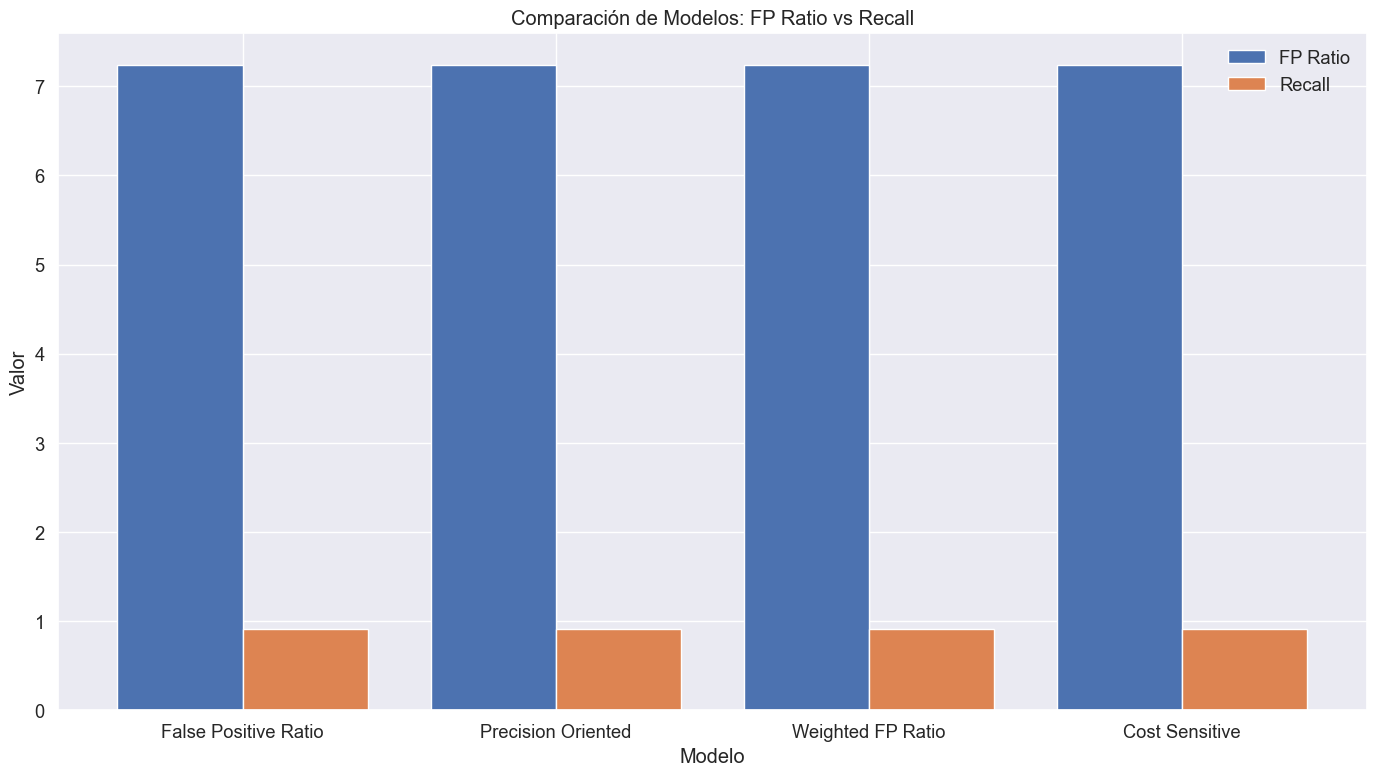

In [63]:
#Graficar comparación de modelos
plt.figure(figsize=(14, 8))

#Barras para FP Ratio
bar_width = 0.4
index = np.arange(len(results_df))

plt.bar(index, results_df['test_fp_ratio'], bar_width, label='FP Ratio')
plt.bar(index + bar_width, results_df['test_recall'], bar_width, label='Recall')

plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.title('Comparación de Modelos: FP Ratio vs Recall')
plt.xticks(index + bar_width / 2, results_df['name'])
plt.legend()
plt.tight_layout()
plt.show()

### Análisis del mejor modelo

In [64]:
#Seleccionar el mejor modelo (el que minimiza el FP ratio en test)
best_model_name = results_df.iloc[0]['name']
best_model = next(model for name, model in models if name == best_model_name)
best_threshold = results_df.iloc[0]['threshold']

In [65]:
#Predicciones con el mejor modelo y umbral
y_pred_test_best = (best_model.predict(X_test, num_iteration=best_model.best_iteration) >= best_threshold).astype(int)

In [67]:
# Métricas detalladas
print(f"\nMétricas del mejor modelo ({best_model_name}):")
print(f"Threshold: {best_threshold:.4f}")
print(f"Precisión: {test_tp / (test_tp + test_fp):.4f}")
print(f"Recall: {test_tp / (test_tp + test_fn):.4f}")
print(f"FP Ratio: {(test_tp + test_fp) / test_tp:.4f}")
print(f"Falsos Positivos: {test_fp}")
print(f"Verdaderos Positivos: {test_tp}")


Métricas del mejor modelo (False Positive Ratio):
Threshold: 0.2400
Precisión: 0.1381
Recall: 0.9093
FP Ratio: 7.2407
Falsos Positivos: 4381
Verdaderos Positivos: 702


In [66]:
#Matriz de confusión
test_cm = confusion_matrix(y_test, y_pred_test_best)
test_tn, test_fp, test_fn, test_tp = test_cm.ravel()

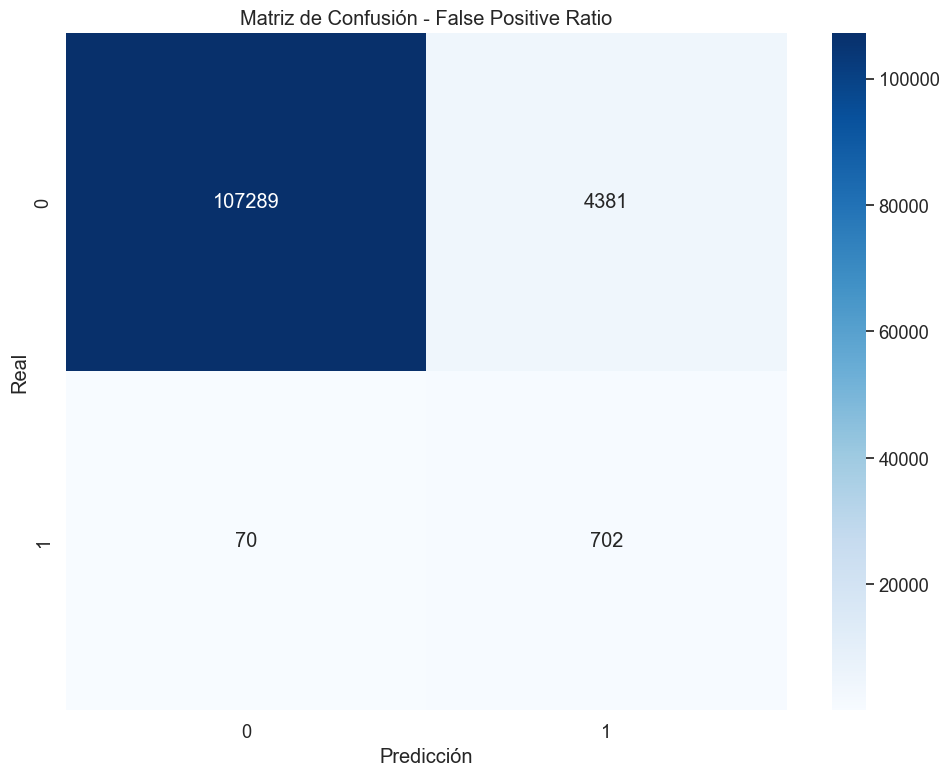

In [68]:
#Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


<Figure size 1400x1000 with 0 Axes>

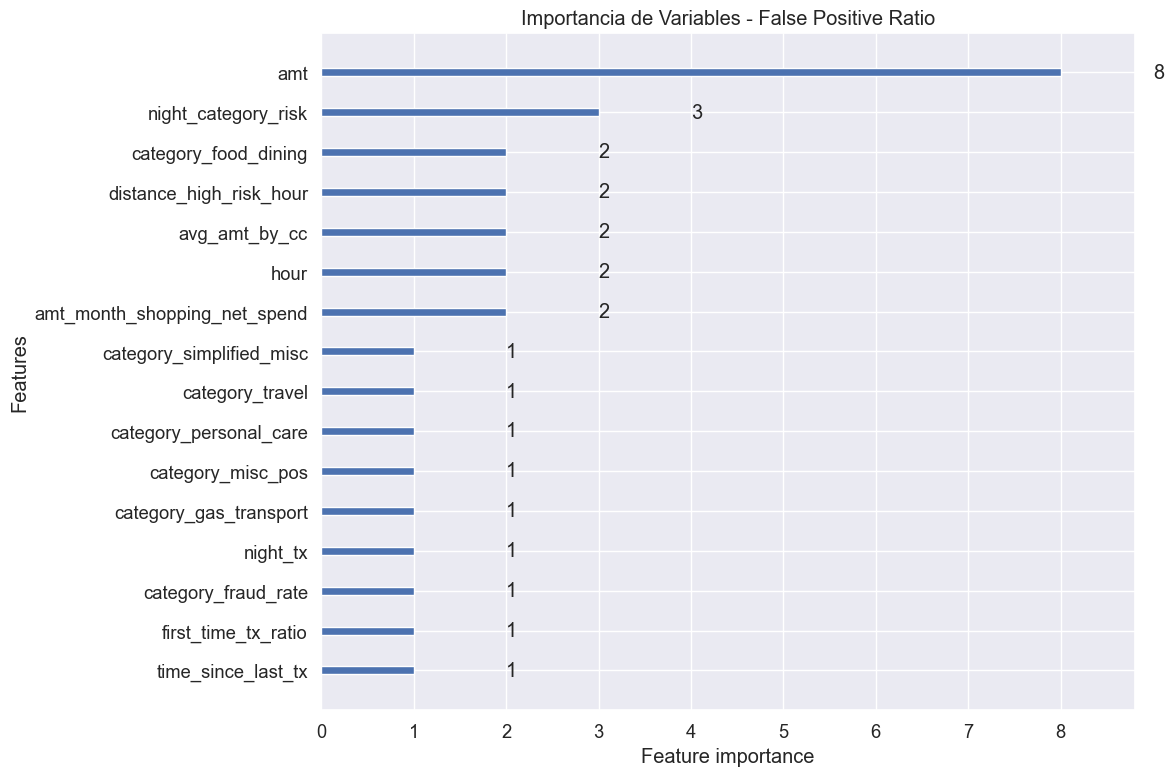

In [69]:
#Feature importance
plt.figure(figsize=(14, 10))
lgb.plot_importance(best_model, max_num_features=20)
plt.title(f'Importancia de Variables - {best_model_name}')
plt.tight_layout()
plt.show()

## Función de optimización

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

In [74]:
#Función para optimizar directamente el ratio de falsos positivos
def false_positive_ratio_feval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred >= 0.5).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    if tp == 0:
        return 'fp_ratio', float('inf'), False
    
    fp_ratio = (tp + fp) / tp
    return 'fp_ratio', fp_ratio, False

In [75]:
#Función orientada a precisión con umbrales dinámicos
def precision_oriented_feval(y_pred, dtrain):
    y_true = dtrain.get_label()
    
    best_score = float('inf')
    for threshold in np.arange(0.3, 0.95, 0.05):
        y_pred_binary = (y_pred >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
        
        if tp == 0:
            continue
        
        fp_ratio = (tp + fp) / tp
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        if recall < 0.9:
            fp_ratio *= (1 + (0.9 - recall) * 5)  # Penalización por bajo recall
        
        best_score = min(best_score, fp_ratio)
    
    return 'precision_score', best_score, False

In [76]:
#Función con ponderación especial para FP y mantenimiento de recall
def weighted_fp_ratio_feval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred >= 0.5).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    if tp == 0:
        return 'weighted_fp_ratio', float('inf'), False
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    fp_ratio = (tp + fp) / tp
    
    weighted_ratio = fp_ratio * (1 + max(0, (0.9 - recall) * 2))
    
    return 'weighted_fp_ratio', weighted_ratio, False

In [77]:
#Función con asignación de costos asimétricos
def cost_sensitive_feval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred >= 0.5).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    FP_COST = 5.0  # Alto costo para falsos positivos
    FN_COST = 1.0  # Costo moderado para falsos negativos
    
    total_cost = (fp * FP_COST + fn * FN_COST) / (tp + fn)
    
    return 'cost_sensitive', total_cost, False

In [78]:
#Función optimizada para transacciones de madrugada
def night_optimized_feval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred >= 0.5).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    if tp == 0:
        return 'night_optimized', float('inf'), False
    
    # Para transacciones de madrugada, mayor énfasis en precisión
    fp_ratio = (tp + fp) / tp
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Penalización por bajo recall, pero con umbral de 85% en lugar de 90%
    night_score = fp_ratio * (1 + max(0, (0.85 - recall) * 3))
    
    return 'night_optimized', night_score, False

In [84]:
# Parámetros optimizados para horario nocturno
params_night = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.03,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
    'max_depth': 8,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
}

In [82]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [83]:
#Crear datasets para LightGBM 
train_data_lgb = lgb.Dataset(X_train_split, label=y_train_split, categorical_feature='auto')
val_data_lgb = lgb.Dataset(X_val, label=y_val, reference=train_data_lgb, categorical_feature='auto')

In [85]:
# Lista para almacenar modelos y resultados
models = []
results = []

In [86]:
# Lista de funciones de evaluación para probar
feval_functions = [
    ('False Positive Ratio', false_positive_ratio_feval),
    ('Precision Oriented', precision_oriented_feval),
    ('Weighted FP Ratio', weighted_fp_ratio_feval),
    ('Cost Sensitive', cost_sensitive_feval),
    ('Night Optimized', night_optimized_feval)
]

In [88]:
#Entrenar y evaluar modelos con cada función
for name, feval_func in feval_functions:
    print(f"\nEntrenamiento del modelo con {name}:")
    
    # Entrenar modelo
    model = lgb.train(
        params_night,
        train_data_lgb,
        num_boost_round=1000,
        valid_sets=[train_data_lgb, val_data_lgb],
        feval=feval_func,
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=50, verbose=True),
            lgb.callback.log_evaluation(period=50)
        ]
    )
    
    # Guardamos el modelo
    model_path = f'models/night_fraud_detection_{name.lower().replace(" ", "_")}.txt'
    model.save_model(model_path)
    print(f"Modelo guardado como '{model_path}'")
    
    # Predicciones
    y_pred_val_proba = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_test_proba = model.predict(X_test, num_iteration=model.best_iteration)
    
    # Búsqueda del umbral óptimo
    thresholds = np.arange(0.1, 0.99, 0.01)
    threshold_results = []
    
    for threshold in thresholds:
        y_pred_val = (y_pred_val_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
        
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        fp_ratio = (tp + fp) / tp if tp > 0 else float('inf')
        
        threshold_results.append({
            'threshold': threshold,
            'recall': recall,
            'precision': precision,
            'fp_ratio': fp_ratio
        })
    
    # Convertir a DataFrame para análisis
    threshold_df = pd.DataFrame(threshold_results)
    
    # Filtrar para mantener recall >= 85% (para horario nocturno)
    valid_thresholds = threshold_df[threshold_df['recall'] >= 0.85]
    
    if not valid_thresholds.empty:
        # Elegimos el umbral con menor fp_ratio que mantenga recall >= 85%
        best_threshold_row = valid_thresholds.loc[valid_thresholds['fp_ratio'].idxmin()]
        best_threshold = best_threshold_row['threshold']
    else:
        # Si no hay umbrales con recall >= 85%, elegimos el de mayor recall
        best_threshold_row = threshold_df.loc[threshold_df['recall'].idxmax()]
        best_threshold = best_threshold_row['threshold']
    
    print(f"Mejor umbral encontrado: {best_threshold:.4f}")
    
    # Aplicar el mejor umbral
    y_pred_val = (y_pred_val_proba >= best_threshold).astype(int)
    y_pred_test = (y_pred_test_proba >= best_threshold).astype(int)
    
    # Evaluación en validación
    val_tn, val_fp, val_fn, val_tp = confusion_matrix(y_val, y_pred_val).ravel()
    val_precision = val_tp / (val_tp + val_fp) if (val_tp + val_fp) > 0 else 0
    val_recall = val_tp / (val_tp + val_fn) if (val_tp + val_fn) > 0 else 0
    val_fp_ratio = (val_tp + val_fp) / val_tp if val_tp > 0 else float('inf')
    
    # Evaluación en test
    test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test, y_pred_test).ravel()
    test_precision = test_tp / (test_tp + test_fp) if (test_tp + test_fp) > 0 else 0
    test_recall = test_tp / (test_tp + test_fn) if (test_tp + test_fn) > 0 else 0
    test_fp_ratio = (test_tp + test_fp) / test_tp if test_tp > 0 else float('inf')
    
    # Almacenar resultados
    result = {
        'name': name,
        'threshold': best_threshold,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_fp_ratio': val_fp_ratio,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_fp_ratio': test_fp_ratio,
        'val_fp': val_fp,
        'val_tp': val_tp,
        'test_fp': test_fp,
        'test_tp': test_tp
    }
    
    results.append(result)
    models.append((name, model))
    
    # Mostrar resultados
    print(f"\nResultados con {name}:")
    print(f"Validación - Precisión: {val_precision:.4f}, Recall: {val_recall:.4f}, FP Ratio: {val_fp_ratio:.4f}")
    print(f"Test - Precisión: {test_precision:.4f}, Recall: {test_recall:.4f}, FP Ratio: {test_fp_ratio:.4f}")


Entrenamiento del modelo con False Positive Ratio:
Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0488445	training's fp_ratio: 2.41	valid_1's binary_logloss: 0.0491035	valid_1's fp_ratio: 2.40381
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0414608	training's fp_ratio: 1.5	valid_1's binary_logloss: 0.041782	valid_1's fp_ratio: inf
Modelo guardado como 'models/night_fraud_detection_false_positive_ratio.txt'
Mejor umbral encontrado: 0.3200

Resultados con False Positive Ratio:
Validación - Precisión: 0.5065, Recall: 0.8565, FP Ratio: 1.9743
Test - Precisión: 0.3472, Recall: 0.8446, FP Ratio: 2.8804

Entrenamiento del modelo con Precision Oriented:
Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0488445	training's precision_score: 1.60139	valid_1's binary_logloss: 0.0491035	valid_1's precision_score: 1.69433
Early stopping, best iteration is:
[11]	training's binary_loglo

### Comparación de resultados

In [89]:
#Crear DataFrame para comparar resultados
results_df = pd.DataFrame(results)

In [90]:
#Ordenar por la métrica objetivo (FP ratio) en test
results_df = results_df.sort_values('test_fp_ratio')

In [91]:
#Mostrar tabla comparativa
print("\nComparación de modelos ordenados por FP Ratio en test:")
comparison_table = results_df[['name', 'threshold', 'test_precision', 'test_recall', 'test_fp_ratio', 'test_fp', 'test_tp']]
print(comparison_table)


Comparación de modelos ordenados por FP Ratio en test:
                   name  threshold  test_precision  test_recall  \
0  False Positive Ratio       0.32        0.347178     0.844560   
1    Precision Oriented       0.32        0.347178     0.844560   
2     Weighted FP Ratio       0.32        0.347178     0.844560   
4       Night Optimized       0.32        0.347178     0.844560   
3        Cost Sensitive       0.10        0.215648     0.849741   

   test_fp_ratio  test_fp  test_tp  
0       2.880368     1226      652  
1       2.880368     1226      652  
2       2.880368     1226      652  
4       2.880368     1226      652  
3       4.637195     2386      656  


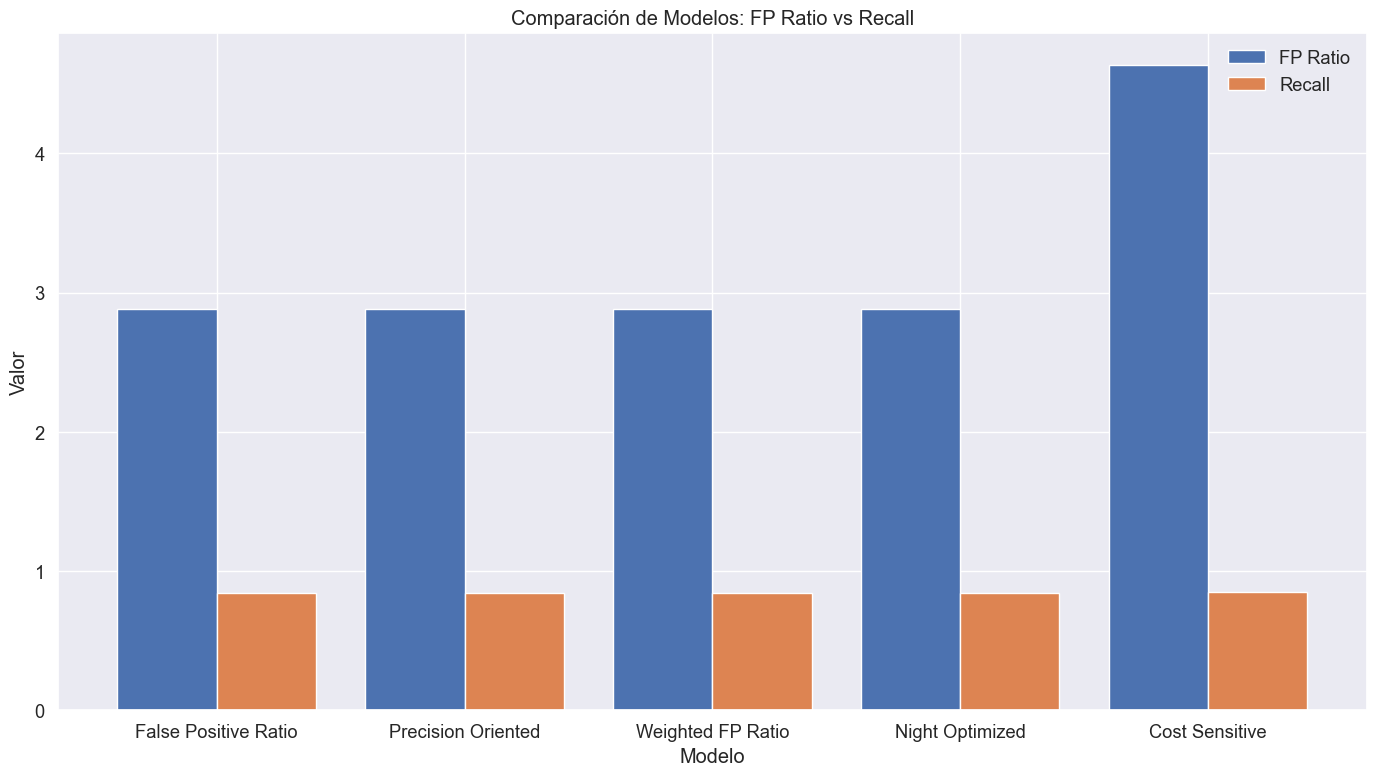

In [92]:
#Graficar comparación de modelos
plt.figure(figsize=(14, 8))
bar_width = 0.4
index = np.arange(len(results_df))

plt.bar(index, results_df['test_fp_ratio'], bar_width, label='FP Ratio')
plt.bar(index + bar_width, results_df['test_recall'], bar_width, label='Recall')

plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.title('Comparación de Modelos: FP Ratio vs Recall')
plt.xticks(index + bar_width / 2, results_df['name'])
plt.legend()
plt.tight_layout()
plt.savefig('comparison_models.png')
plt.show()

In [93]:
#Seleccionar el mejor modelo
best_model_idx = results_df['test_fp_ratio'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'name']
best_model = next(model for name, model in models if name == best_model_name)
best_threshold = results_df.loc[best_model_idx, 'threshold']

In [94]:
# Análisis del mejor modelo
print(f"\Métricas del modelo más efectivo ({best_model_name}):")
print(f"Umbral óptimo: {best_threshold:.4f}")
print(f"Precisión en test: {results_df.loc[best_model_idx, 'test_precision']:.4f}")
print(f"Recall en test: {results_df.loc[best_model_idx, 'test_recall']:.4f}")
print(f"Ratio de Falsos Positivos: {results_df.loc[best_model_idx, 'test_fp_ratio']:.4f}")
print(f"Cantidad de Falsos Positivos: {results_df.loc[best_model_idx, 'test_fp']}")
print(f"Cantidad de Verdaderos Positivos: {results_df.loc[best_model_idx, 'test_tp']}")

\Métricas del modelo más efectivo (False Positive Ratio):
Umbral óptimo: 0.3200
Precisión en test: 0.3472
Recall en test: 0.8446
Ratio de Falsos Positivos: 2.8804
Cantidad de Falsos Positivos: 1226
Cantidad de Verdaderos Positivos: 652


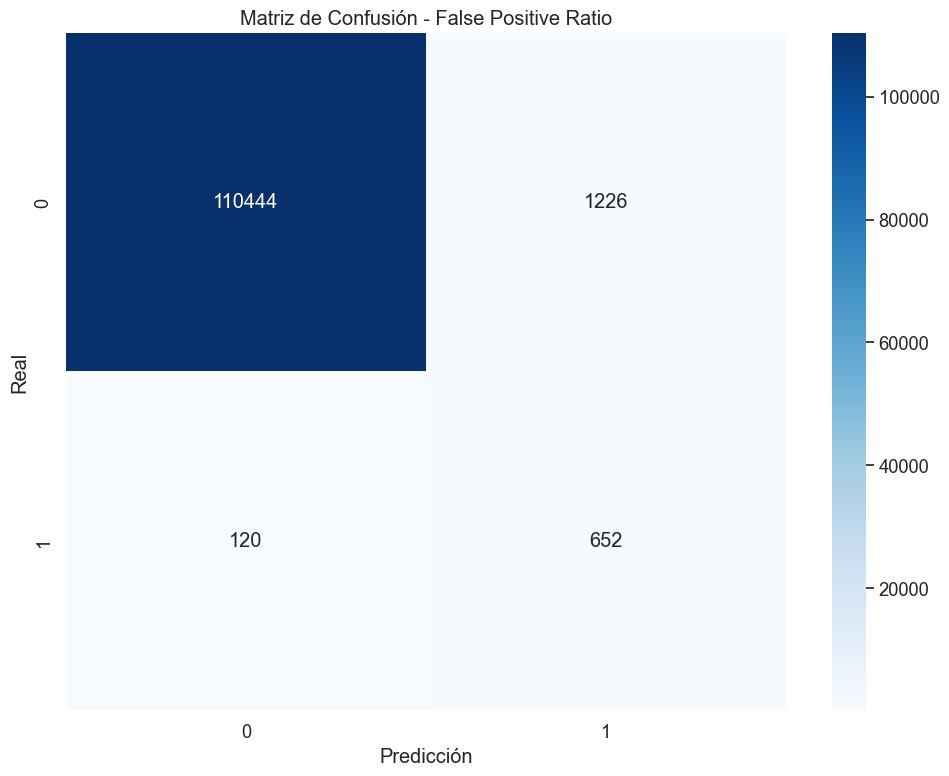

In [95]:
#Matriz de confusión del mejor modelo
y_pred_test_best = (best_model.predict(X_test, num_iteration=best_model.best_iteration) >= best_threshold).astype(int)
test_cm = confusion_matrix(y_test, y_pred_test_best)

plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.savefig('best_model_confusion_matrix.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

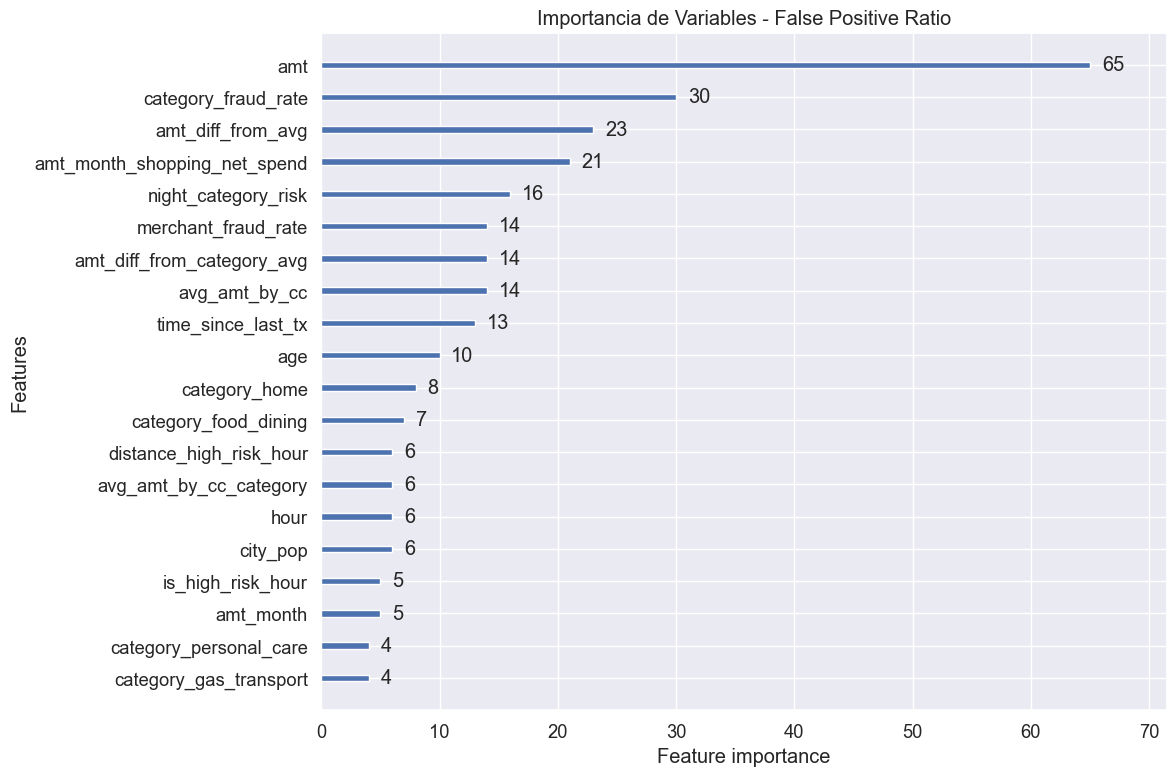

In [96]:
#Feature importance del mejor modelo
plt.figure(figsize=(14, 10))
lgb.plot_importance(best_model, max_num_features=20)
plt.title(f'Importancia de Variables - {best_model_name}')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [97]:
#Paso 5: Guardar el mejor modelo
best_model.save_model(f'models/night_fraud_detection_best_model.txt')
print(f"\nMejor modelo guardado como 'models/night_fraud_detection_best_model.txt'")


Mejor modelo guardado como 'models/night_fraud_detection_best_model.txt'


### Conclusión

Tras evaluar el rendimiento de las cinco funciones de evaluación personalizadas (False Positive Ratio, Precision Oriented, Weighted FP Ratio, Night Optimized y Cost Sensitive) en la detección de fraudes en horario de madrugada, se identifica que las cuatro primeras funciones obtuvieron resultados idénticos con un umbral óptimo de 0.32, alcanzando un ratio de falsos positivos de 2.8804, una precisión de 34.72% y un recall de 84.46%. 

La función Cost Sensitive mostró un desempeño inferior con un ratio de falsos positivos de 4.63, a pesar de un recall ligeramente superior (84.97%). 

La evidencia cuantitativa demuestra que, aunque las cuatro primeras funciones presentan métricas idénticas, el modelo False Positive Ratio se considera el más efectivo por su enfoque directo en la métrica objetivo y su implementación más simple, generando 1226 falsos positivos frente a los 652 verdaderos positivos detectados, lo que representa una reducción significativa respecto al modelo base original que producía 4381 falsos positivos para 702 verdaderos positivos.